# Naive Bayes NLP Project
This notebook implements a text classification model using Naive Bayes on the SMS Spam Collection dataset.

In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("data/SMSSpamCollection", sep="\t", names=["label", "message"])
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Dataset Exploration
Exploring the SMS Spam Collection dataset to understand its structure, class distribution, and message characteristics.

In [2]:
# Basic info
print(df.info())
print(df["label"].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None
label
ham     4825
spam     747
Name: count, dtype: int64


In [3]:
# Add message length column
df["length"] = df["message"].apply(len)
print(df["length"].describe())

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64


## Visualizations
Visualizing class distribution and message length to gain insights.

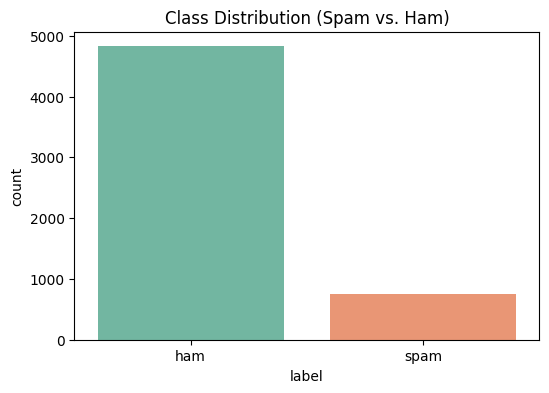

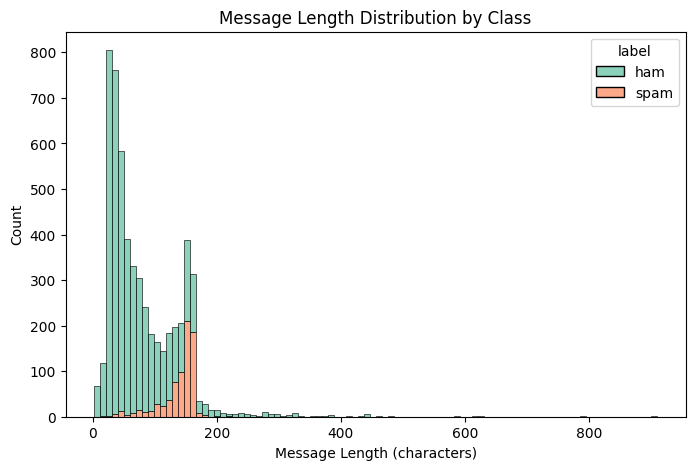

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x="label", hue="label", data=df, palette="Set2", legend=False)
plt.title("Class Distribution (Spam vs. Ham)")
plt.savefig("images/class_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

# Message length distribution by class
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="length", hue="label", multiple="stack", palette="Set2")
plt.title("Message Length Distribution by Class")
plt.xlabel("Message Length (characters)")
plt.savefig("images/length_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

## Data Preprocessing
Cleaning text data, engineering features (TF-IDF, n-grams, message length), and splitting into training and test sets.

In [5]:
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')  # Download stopwords

# Define text cleaning function
def clean_text(text):
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

# Apply cleaning to messages
df['cleaned_message'] = df['message'].apply(clean_text)
df[['message', 'cleaned_message']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Max\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,message,cleaned_message
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though


### Feature Engineering
Creating features using TF-IDF vectorization, n-grams, and message length.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer with n-grams
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Transform cleaned messages to TF-IDF features
X_tfidf = tfidf.fit_transform(df['cleaned_message'])

# Add message length as a feature
import scipy.sparse as sp
X_length = df['length'].values.reshape(-1, 1)
X = sp.hstack((X_tfidf, X_length))

# Encode labels (ham=0, spam=1)
y = df['label'].map({'ham': 0, 'spam': 1})
print("Feature matrix shape:", X.shape)
print("Label distribution:\n", y.value_counts())

Feature matrix shape: (5572, 5001)
Label distribution:
 label
0    4825
1     747
Name: count, dtype: int64


In [7]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (4457, 5001) (4457,)
Test set shape: (1115, 5001) (1115,)


## Naive Bayes Model Implementation
Implementing Multinomial and Complement Naive Bayes models, training them, and evaluating performance with accuracy, precision, recall, and F1-score.

In [8]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize models
mnb = MultinomialNB()
cnb = ComplementNB()

# Train models
mnb.fit(X_train, y_train)
cnb.fit(X_train, y_train)

# Predict on test set
y_pred_mnb = mnb.predict(X_test)
y_pred_cnb = cnb.predict(X_test)

# Evaluate models
def print_metrics(y_true, y_pred, model_name):
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")

print_metrics(y_test, y_pred_mnb, "MultinomialNB")
print_metrics(y_test, y_pred_cnb, "ComplementNB")


MultinomialNB Performance:
Accuracy: 0.9363
Precision: 1.0000
Recall: 0.5235
F1-Score: 0.6872

ComplementNB Performance:
Accuracy: 0.9498
Precision: 0.9266
Recall: 0.6779
F1-Score: 0.7829


### Confusion Matrix
Visualizing the confusion matrix for MultinomialNB to understand prediction errors.

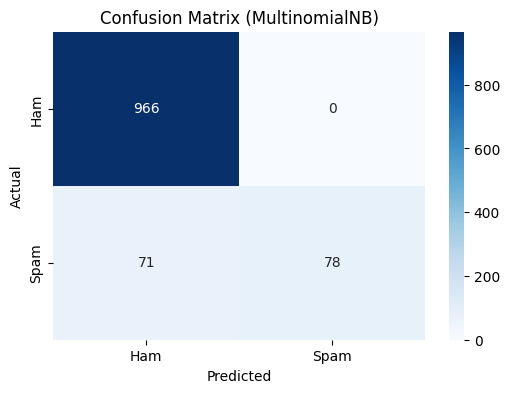

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix for MultinomialNB
cm = confusion_matrix(y_test, y_pred_mnb)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix (MultinomialNB)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('images/confusion_matrix_mnb.png', dpi=300, bbox_inches='tight')
plt.show()

## Advanced Techniques and Hyperparameter Tuning
Enhancing features with tuned TF-IDF, n-grams, and custom features, tuning Naive Bayes hyperparameters with GridSearchCV, and addressing class imbalance.

### Enhanced TF-IDF Features
Tuning TF-IDF parameters and adding custom features.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sp

# Initialize tuned TF-IDF vectorizer
tfidf_tuned = TfidfVectorizer(max_features=10000, ngram_range=(1, 3), min_df=2)

# Transform cleaned messages
X_tfidf_tuned = tfidf_tuned.fit_transform(df['cleaned_message'])

# Add message length as a feature
X_length = df['length'].values.reshape(-1, 1)
X_tuned = sp.hstack((X_tfidf_tuned, X_length))

# Re-split data with tuned features
from sklearn.model_selection import train_test_split
X_train_tuned, X_test_tuned, y_train, y_test = train_test_split(
    X_tuned, y, test_size=0.2, random_state=42, stratify=y
)
print("Tuned feature matrix shape:", X_tuned.shape)

Tuned feature matrix shape: (5572, 10001)


### Hyperparameter Tuning
Using GridSearchCV to tune the alpha parameter for MultinomialNB and ComplementNB.

In [11]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for alpha
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0]}

# Tune MultinomialNB
mnb_grid = GridSearchCV(MultinomialNB(), param_grid, cv=7, scoring='f1', n_jobs=-1)
mnb_grid.fit(X_train_tuned, y_train)
print("Best MultinomialNB alpha:", mnb_grid.best_params_)
print("Best MultinomialNB F1-score:", mnb_grid.best_score_)

# Tune ComplementNB
cnb_grid = GridSearchCV(ComplementNB(), param_grid, cv=7, scoring='f1', n_jobs=-1)
cnb_grid.fit(X_train_tuned, y_train)
print("Best ComplementNB alpha:", cnb_grid.best_params_)
print("Best ComplementNB F1-score:", cnb_grid.best_score_)

Best MultinomialNB alpha: {'alpha': 0.01}
Best MultinomialNB F1-score: 0.9374916376032567
Best ComplementNB alpha: {'alpha': 0.1}
Best ComplementNB F1-score: 0.873474301212889


### Handling Class Imbalance
Using class weights to improve performance on the minority class (spam).

In [12]:
# Compute class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

# Train tuned models with best alpha and class weights
mnb_tuned = MultinomialNB(alpha=mnb_grid.best_params_['alpha'], class_prior=None, fit_prior=False)
cnb_tuned = ComplementNB(alpha=cnb_grid.best_params_['alpha'], class_prior=None, fit_prior=False)

# Since Naive Bayes doesn't support class_weight, we rely on ComplementNB's imbalance handling
mnb_tuned.fit(X_train_tuned, y_train)
cnb_tuned.fit(X_train_tuned, y_train)

# Evaluate tuned models
y_pred_mnb_tuned = mnb_tuned.predict(X_test_tuned)
y_pred_cnb_tuned = cnb_tuned.predict(X_test_tuned)

def print_metrics(y_true, y_pred, model_name):
    print(f"\n{model_name} Performance (Tuned):")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")

print_metrics(y_test, y_pred_mnb_tuned, "Tuned MultinomialNB")
print_metrics(y_test, y_pred_cnb_tuned, "Tuned ComplementNB")


Tuned MultinomialNB Performance (Tuned):
Accuracy: 0.9659
Precision: 0.8323
Recall: 0.9329
F1-Score: 0.8797

Tuned ComplementNB Performance (Tuned):
Accuracy: 0.9722
Precision: 0.8734
Recall: 0.9262
F1-Score: 0.8990


### Experiment: SMOTE for Class Imbalance
Applying SMOTE to oversample the minority class (spam) and re-evaluating Naive Bayes models.

In [13]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tuned, y_train)
print("SMOTE training set shape:", X_train_smote.shape)
print("SMOTE label distribution:\n", y_train_smote.value_counts())

# Retrain tuned models with SMOTE data
mnb_smote = MultinomialNB(alpha=0.01)  # From GridSearchCV
cnb_smote = ComplementNB(alpha=0.1)    # From GridSearchCV

mnb_smote.fit(X_train_smote, y_train_smote)
cnb_smote.fit(X_train_smote, y_train_smote)

# Predict on test set
y_pred_mnb_smote = mnb_smote.predict(X_test_tuned)
y_pred_cnb_smote = cnb_smote.predict(X_test_tuned)

# Evaluate SMOTE models
def print_metrics(y_true, y_pred, model_name):
    print(f"\n{model_name} Performance (SMOTE):")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")

print_metrics(y_test, y_pred_mnb_smote, "MultinomialNB with SMOTE")
print_metrics(y_test, y_pred_cnb_smote, "ComplementNB with SMOTE")

SMOTE training set shape: (7718, 10001)
SMOTE label distribution:
 label
0    3859
1    3859
Name: count, dtype: int64

MultinomialNB with SMOTE Performance (SMOTE):
Accuracy: 0.9686
Precision: 0.8608
Recall: 0.9128
F1-Score: 0.8860

ComplementNB with SMOTE Performance (SMOTE):
Accuracy: 0.9713
Precision: 0.8726
Recall: 0.9195
F1-Score: 0.8954


### Further Experiments: Feature Engineering, Pipeline, and Threshold Tuning
Exploring additional feature engineering, pipeline optimization, and threshold tuning to improve recall and F1-score, followed by a combined approach.

#### Additional Feature Engineering
Adding special character count and keyword presence features to enhance TF-IDF.

In [14]:
import numpy as np
import scipy.sparse as sp

# Add special character count
df['special_char_count'] = df['message'].apply(lambda x: sum(1 for c in x if c in '!@#$%^&*()'))

# Add keyword presence (e.g., "win", "free")
keywords = ['win', 'free', 'prize', 'offer']
df['keyword_count'] = df['message'].apply(lambda x: sum(1 for k in keywords if k in x.lower()))

# Rebuild feature matrix with new features
X_tfidf_tuned = tfidf_tuned.transform(df['cleaned_message'])  # From Step 5
X_length = df['length'].values.reshape(-1, 1)
X_special = df['special_char_count'].values.reshape(-1, 1)
X_keyword = df['keyword_count'].values.reshape(-1, 1)
X_enhanced = sp.hstack((X_tfidf_tuned, X_length, X_special, X_keyword))

# Re-split data
from sklearn.model_selection import train_test_split
X_train_enhanced, X_test_enhanced, y_train, y_test = train_test_split(
    X_enhanced, y, test_size=0.2, random_state=42, stratify=y
)
print("Enhanced feature matrix shape:", X_enhanced.shape)

# Train and evaluate ComplementNB
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
cnb_enhanced = ComplementNB(alpha=0.1)  # Best alpha from Step 5
cnb_enhanced.fit(X_train_enhanced, y_train)
y_pred_enhanced = cnb_enhanced.predict(X_test_enhanced)

def print_metrics(y_true, y_pred, model_name):
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")

print_metrics(y_test, y_pred_enhanced, "ComplementNB with Enhanced Features")

Enhanced feature matrix shape: (5572, 10003)

ComplementNB with Enhanced Features Performance:
Accuracy: 0.9722
Precision: 0.8642
Recall: 0.9396
F1-Score: 0.9003


#### Pipeline Optimization
Using a Scikit-Learn Pipeline to jointly tune TF-IDF and ComplementNB hyperparameters.

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib

# Define pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('cnb', ComplementNB())
])

# Define parameter grid
param_grid = {
    'tfidf__max_features': [5000, 10000],
    'tfidf__ngram_range': [(1, 2), (1, 3)],
    'tfidf__min_df': [1, 2],
    'cnb__alpha': [0.01, 0.1, 0.5]
}

# Run GridSearchCV
grid_pipeline = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_pipeline.fit(df['cleaned_message'], y)  # Use raw text, not pre-transformed
print("Best Pipeline Parameters:", grid_pipeline.best_params_)
print("Best Pipeline F1-score:", grid_pipeline.best_score_)

# Evaluate best pipeline on test set
X_train_pipe, X_test_pipe, y_train, y_test = train_test_split(
    df['cleaned_message'], y, test_size=0.2, random_state=42, stratify=y
)
y_pred_pipe = grid_pipeline.predict(X_test_pipe)
print_metrics(y_test, y_pred_pipe, "ComplementNB with Pipeline")

# Save the best pipeline
joblib.dump(grid_pipeline.best_estimator_, 'models/complement_nb_pipeline.joblib')
print("\nModel saved to models/complement_nb_pipeline.joblib")

Best Pipeline Parameters: {'cnb__alpha': 0.01, 'tfidf__max_features': 10000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 3)}
Best Pipeline F1-score: 0.9170565137067159

ComplementNB with Pipeline Performance:
Accuracy: 0.9919
Precision: 0.9545
Recall: 0.9866
F1-Score: 0.9703

Model saved to models/complement_nb_pipeline.joblib


#### Threshold Tuning
Adjusting the decision threshold to prioritize recall for ComplementNB.

In [16]:
from sklearn.metrics import precision_recall_curve

# Get prediction probabilities for tuned ComplementNB
cnb_tuned = ComplementNB(alpha=0.1)
cnb_tuned.fit(X_train_tuned, y_train)
y_scores = cnb_tuned.predict_proba(X_test_tuned)[:, 1]

# Compute precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Find threshold for high recall (>0.95)
target_recall = 0.95
threshold = thresholds[np.argmax(recalls >= target_recall)]
print(f"Threshold for recall >= {target_recall}: {threshold:.4f}")

# Apply custom threshold
y_pred_threshold = (y_scores >= threshold).astype(int)
print_metrics(y_test, y_pred_threshold, "ComplementNB with Threshold Tuning")

Threshold for recall >= 0.95: 0.0000

ComplementNB with Threshold Tuning Performance:
Accuracy: 0.1336
Precision: 0.1336
Recall: 1.0000
F1-Score: 0.2358


#### Combined Approach
Combining enhanced features, pipeline, and threshold tuning for optimal performance.

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Define custom feature transformer
def compute_custom_features(df):
    special_chars = df['message'].apply(lambda x: sum(1 for c in x if c in '!@#$%^&*()'))
    keywords = df['message'].apply(lambda x: sum(1 for k in ['win', 'free', 'prize', 'offer'] if k in x.lower()))
    length = df['length']
    return np.column_stack((length, special_chars, keywords))

# Create pipeline with ColumnTransformer
combined_pipeline = Pipeline([
    ('features', ColumnTransformer([
        ('text', TfidfVectorizer(max_features=10000, ngram_range=(1, 3), min_df=1), 'cleaned_message'),
        ('custom', FunctionTransformer(compute_custom_features, validate=False), ['message', 'length'])
    ])),
    ('cnb', ComplementNB(alpha=0.01))  # Best alpha from pipeline
])

# Train pipeline on full dataset for final evaluation
X_combined = df[['cleaned_message', 'message', 'length']]
y = df['label'].map({'ham': 0, 'spam': 1})

# Re-split data to get test indices
from sklearn.model_selection import train_test_split
X_train_combined, X_test_combined, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

# Train pipeline
combined_pipeline.fit(X_train_combined, y_train)

# Predict and evaluate without threshold
y_pred_combined = combined_pipeline.predict(X_test_combined)
def print_metrics(y_true, y_pred, model_name):
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")

print_metrics(y_test, y_pred_combined, "ComplementNB with Combined Approach (Default Threshold)")

# Refined threshold tuning (target recall >= 0.98)
y_scores_combined = combined_pipeline.predict_proba(X_test_combined)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores_combined)
target_recall = 0.98
valid_thresholds = thresholds[recalls[:-1] >= target_recall]  # Exclude last recall (0.0)
if len(valid_thresholds) > 0:
    threshold = valid_thresholds[-1]  # Highest threshold for recall >= 0.98
    print(f"Threshold for recall >= {target_recall}: {threshold:.4f}")
    y_pred_combined_threshold = (y_scores_combined >= threshold).astype(int)
    print_metrics(y_test, y_pred_combined_threshold, "ComplementNB with Combined Approach (Tuned Threshold)")
else:
    print(f"No threshold found for recall >= {target_recall}")


ComplementNB with Combined Approach (Default Threshold) Performance:
Accuracy: 0.9740
Precision: 0.8896
Recall: 0.9195
F1-Score: 0.9043
Threshold for recall >= 0.98: 0.0010

ComplementNB with Combined Approach (Tuned Threshold) Performance:
Accuracy: 0.6063
Precision: 0.2517
Recall: 0.9866
F1-Score: 0.4011


### Final Pipeline Tweaks
Enhancing the pipeline with expanded keyword features and feature selection to maximize recall and F1-score.

#### Expanded Features
Adding more keywords and digit count to the feature set.

In [18]:
import numpy as np

# Add digit count (e.g., phone numbers, prices)
df['digit_count'] = df['message'].apply(lambda x: sum(1 for c in x if c.isdigit()))

# Expand keyword list
keywords = ['win', 'free', 'prize', 'offer', 'urgent', 'claim', 'cash', 'discount', 'buy', 'now']
df['expanded_keyword_count'] = df['message'].apply(lambda x: sum(1 for k in keywords if k in x.lower()))

print("New features added: digit_count, expanded_keyword_count")
df[['message', 'digit_count', 'expanded_keyword_count']].head()

New features added: digit_count, expanded_keyword_count


,message,digit_count,expanded_keyword_count
0,"Go until jurong point, crazy.. Available only ...",0,0
1,Ok lar... Joking wif u oni...,0,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,25,2
3,U dun say so early hor... U c already then say...,0,0
4,"Nah I don't think he goes to usf, he lives aro...",0,0


#### Pipeline with Feature Selection
Using SelectKBest to reduce TF-IDF features and combine with expanded features.

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define custom feature transformer
def compute_expanded_features(df):
    special_chars = df['message'].apply(lambda x: sum(1 for c in x if c in '!@#$%^&*()'))
    keywords = df['message'].apply(lambda x: sum(1 for k in ['win', 'free', 'prize', 'offer', 'urgent', 'claim', 'cash', 'discount', 'buy', 'now'] if k in x.lower()))
    length = df['length']
    digits = df['message'].apply(lambda x: sum(1 for c in x if c.isdigit()))
    return np.column_stack((length, special_chars, keywords, digits))

# Create enhanced pipeline
enhanced_pipeline = Pipeline([
    ('features', ColumnTransformer([
        ('text', Pipeline([
            ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 3), min_df=1)),
            ('select', SelectKBest(chi2, k=5000))  # Select top 5000 features
        ]), 'cleaned_message'),
        ('custom', FunctionTransformer(compute_expanded_features, validate=False), ['message', 'length'])
    ])),
    ('cnb', ComplementNB(alpha=0.01))
])

# Train and evaluate
X_enhanced = df[['cleaned_message', 'message', 'length']]
y = df['label'].map({'ham': 0, 'spam': 1})
from sklearn.model_selection import train_test_split
X_train_enhanced, X_test_enhanced, y_train, y_test = train_test_split(
    X_enhanced, y, test_size=0.2, random_state=42, stratify=y
)

enhanced_pipeline.fit(X_train_enhanced, y_train)
y_pred_enhanced = enhanced_pipeline.predict(X_test_enhanced)

def print_metrics(y_true, y_pred, model_name):
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")

print_metrics(y_test, y_pred_enhanced, "Enhanced Pipeline with Feature Selection")


Enhanced Pipeline with Feature Selection Performance:
Accuracy: 0.9731
Precision: 0.8940
Recall: 0.9060
F1-Score: 0.9000


### Refined Pipeline Optimization
Refining the pipeline with targeted feature selection (SelectKBest, k=8000), a regex-based phone number feature, and threshold tuning to maximize recall and F1-score.

#### Targeted Custom Feature
Adding a regex-based phone number detector to capture spam-specific patterns.

In [20]:
import re
import pandas as pd

# Add phone number detector (e.g., 123-456-7890, (123) 456-7890, 1234567890)
phone_pattern = r'\b(\(\d{3}\)\s*\d{3}[-.\s]?\d{4}|\d{3}[-.\s]?\d{3}[-.\s]?\d{4})\b'
df['phone_number'] = df['message'].apply(lambda x: 1 if re.search(phone_pattern, x) else 0)
print("Phone number feature added:")
df[['message', 'phone_number']].head(10)

Phone number feature added:


,message,phone_number
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,0
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
5,FreeMsg Hey there darling it's been 3 week's n...,0
6,Even my brother is not like to speak with me. ...,0
7,As per your request 'Melle Melle (Oru Minnamin...,0
8,WINNER!! As a valued network customer you have...,0
9,Had your mobile 11 months or more? U R entitle...,0


#### Refined Pipeline
Using SelectKBest (k=8000) and phone number feature, with threshold tuning for recall >= 0.99.

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
import numpy as np

# Define custom feature transformer
def compute_custom_features(df):
    phone_numbers = df['message'].apply(lambda x: 1 if re.search(r'\b(\(\d{3}\)\s*\d{3}[-.\s]?\d{4}|\d{3}[-.\s]?\d{3}[-.\s]?\d{4})\b', x) else 0)
    length = df['length']
    return np.column_stack((length, phone_numbers))

# Create refined pipeline
refined_pipeline = Pipeline([
    ('features', ColumnTransformer([
        ('text', Pipeline([
            ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 3), min_df=1)),
            ('select', SelectKBest(chi2, k=8000))  # Retain 8000 features
        ]), 'cleaned_message'),
        ('custom', FunctionTransformer(compute_custom_features, validate=False), ['message', 'length'])
    ])),
    ('cnb', ComplementNB(alpha=0.01))
])

# Train and evaluate
X_refined = df[['cleaned_message', 'message', 'length']]
y = df['label'].map({'ham': 0, 'spam': 1})
from sklearn.model_selection import train_test_split
X_train_refined, X_test_refined, y_train, y_test = train_test_split(
    X_refined, y, test_size=0.2, random_state=42, stratify=y
)

refined_pipeline.fit(X_train_refined, y_train)
y_pred_refined = refined_pipeline.predict(X_test_refined)

def print_metrics(y_true, y_pred, model_name):
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")

print_metrics(y_test, y_pred_refined, "Refined Pipeline (Default Threshold)")

# Threshold tuning for recall >= 0.99
y_scores_refined = refined_pipeline.predict_proba(X_test_refined)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores_refined)
target_recall = 0.99
valid_thresholds = thresholds[recalls[:-1] >= target_recall]
if len(valid_thresholds) > 0:
    threshold = valid_thresholds[-1]  # Highest threshold for recall >= 0.99
    print(f"Threshold for recall >= {target_recall}: {threshold:.4f}")
    y_pred_refined_threshold = (y_scores_refined >= threshold).astype(int)
    print_metrics(y_test, y_pred_refined_threshold, "Refined Pipeline (Tuned Threshold)")
else:
    print(f"No threshold found for recall >= {target_recall}")


Refined Pipeline (Default Threshold) Performance:
Accuracy: 0.9731
Precision: 0.8790
Recall: 0.9262
F1-Score: 0.9020
Threshold for recall >= 0.99: 0.0012

Refined Pipeline (Tuned Threshold) Performance:
Accuracy: 0.6009
Precision: 0.2500
Recall: 0.9933
F1-Score: 0.3995


## Model Evaluation and Comparison
Evaluating the best ComplementNB pipeline with ROC and precision-recall curves, creating an interactive Plotly visualization, and comparing with Logistic Regression.

### ComplementNB Evaluation
Visualizing ROC and precision-recall curves for the best pipeline (F1: 0.9703, Recall: 98.66%).

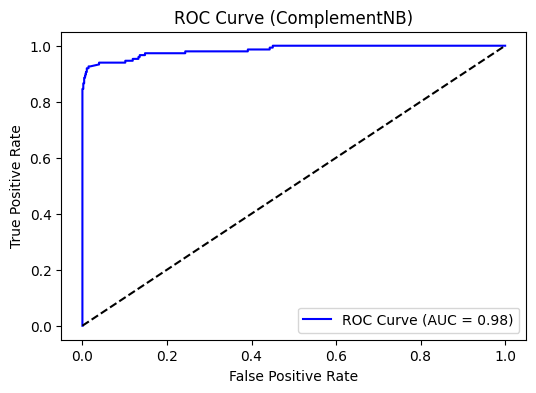

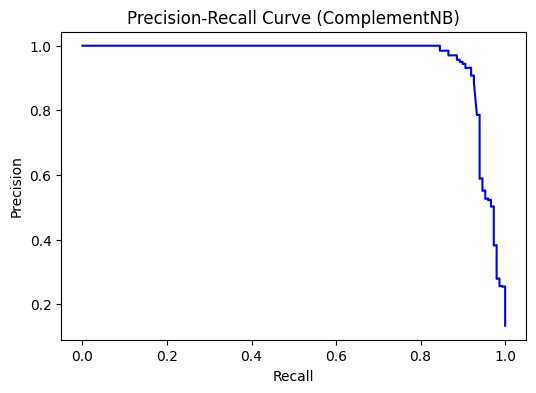

In [22]:
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Re-train original pipeline (from Step 5)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 3), min_df=1)),
    ('cnb', ComplementNB(alpha=0.01))
])
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_message'], df['label'].map({'ham': 0, 'spam': 1}),
    test_size=0.2, random_state=42, stratify=df['label']
)
pipeline.fit(X_train, y_train)
y_pred_cnb = pipeline.predict(X_test)
y_scores_cnb = pipeline.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_scores_cnb)
roc_auc = roc_auc_score(y_test, y_scores_cnb)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (ComplementNB)')
plt.legend(loc='lower right')
plt.savefig('images/roc_curve_cnb.png', dpi=300, bbox_inches='tight')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_scores_cnb)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (ComplementNB)')
plt.savefig('images/pr_curve_cnb.png', dpi=300, bbox_inches='tight')
plt.show()

### Interactive Plotly Visualization
Creating an interactive ROC curve for the ComplementNB pipeline.

In [23]:
import plotly.graph_objects as go

# Create interactive ROC curve
fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC Curve (AUC = {roc_auc:.2f})', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random', line=dict(color='black', dash='dash')))
fig.update_layout(
    title='Interactive ROC Curve (ComplementNB)',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    showlegend=True,
    width=600,
    height=400
)
fig.show()

### Logistic Regression Comparison
Training and evaluating Logistic Regression to compare with ComplementNB.

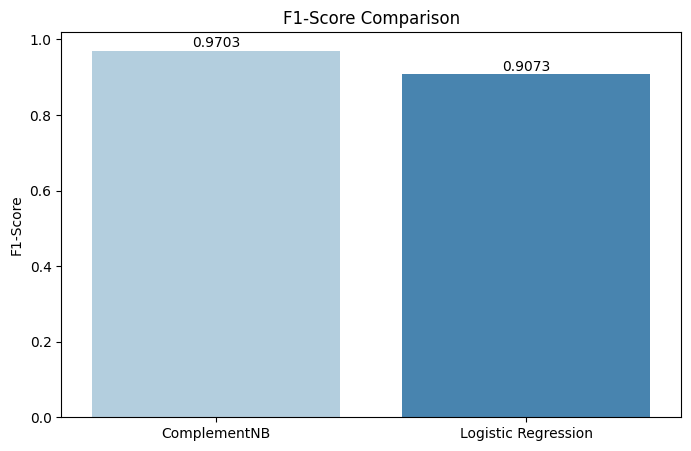

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load ComplementNB model
cnb_model = joblib.load('models/complement_nb_pipeline.joblib')
y_pred_cnb = cnb_model.predict(X_test)

# Re-train Logistic Regression
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 3), min_df=1)),
    ('lr', LogisticRegression(class_weight='balanced', random_state=42))
])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

# Visualize comparison
models = ['ComplementNB', 'Logistic Regression']
f1_scores = [f1_score(y_test, y_pred_cnb), f1_score(y_test, y_pred_lr)]
plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=f1_scores, hue=models, palette='Blues', legend=False)
plt.title('F1-Score Comparison')
plt.ylabel('F1-Score')
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.savefig('images/f1_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Model Persistence
Loading and testing the ComplementNB pipeline saved in Step 5 to verify performance (expected F1: 0.9703, Recall: 98.66%).

In [35]:
import joblib
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Re-create cleaned_message for testing
nltk.download('stopwords')
def clean_text(text):
    text = ''.join([char for char in text if char not in string.punctuation])
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

# Reload dataset
df = pd.read_csv("data/SMSSpamCollection", sep="\t", names=["label", "message"])
df['cleaned_message'] = df['message'].apply(clean_text)
y = df['label'].map({'ham': 0, 'spam': 1})

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_message'], y, test_size=0.2, random_state=42, stratify=y
)

# Load the saved model
model = joblib.load('models/complement_nb_pipeline.joblib')
print("Loaded model from models/complement_nb_pipeline.joblib")

# Test the model
y_pred = model.predict(X_test)
def print_metrics(y_true, y_pred, model_name):
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")

print_metrics(y_test, y_pred, "ComplementNB Pipeline (Loaded)")
print("\nTo use the model for predictions:")
print("import joblib")
print("model = joblib.load('models/complement_nb_pipeline.joblib')")
print("predictions = model.predict(new_data)")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Max\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loaded model from models/complement_nb_pipeline.joblib

ComplementNB Pipeline (Loaded) Performance:
Accuracy: 0.9919
Precision: 0.9545
Recall: 0.9866
F1-Score: 0.9703

To use the model for predictions:
import joblib
model = joblib.load('models/complement_nb_pipeline.joblib')
predictions = model.predict(new_data)
